In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using numpy


In [2]:
nx = 200
ny = 50
steps = 5000
output_stride = 500
molecular_weights = xp.array([2,160])
n_species = len(molecular_weights)
multiplier = 13

Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)

phi_1 = 0.4
phi_2 = phi_1 * molecular_weights[0]/molecular_weights[1]
phis = xp.array([phi_1, phi_2])
print(phis)

Predict diffusion constant =  0.054731728733683496
[0.4   0.005]


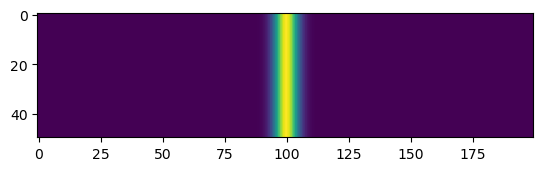

In [3]:
total_pressure = 1
#partial_pressure = xp.array([0.98, 0.02])
#partial_pressure_stripe = xp.array([0.95, 0.05])
partial_pressure_x = np.zeros((n_species, nx))
stripe_width = 5
x_coord = np.arange(nx)
x_gaussian = pow(np.e, -pow((x_coord-nx//2)/stripe_width, 2))

partial_pressure_x[1] = 0.02 + 0.001 * x_gaussian
partial_pressure_x[0] = 1-partial_pressure_x[1]

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure_x[s, :][:, None] * xp.ones((nx,ny))

plt.imshow(rho_s[1,:,:].T)

In [4]:
f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
ux_s = xp.zeros((n_species, nx, ny), dtype=DTYPE)
uy_s = xp.zeros((n_species, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, phis, ux_s, uy_s)
f = feq

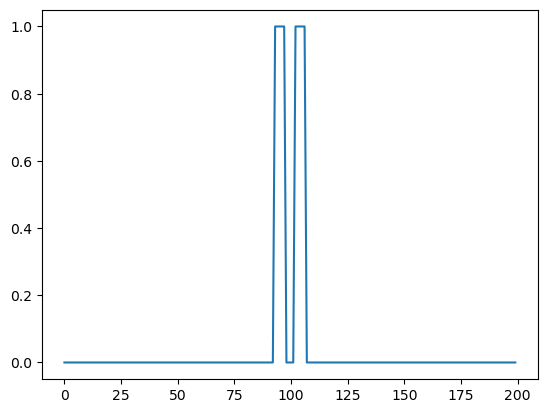

In [5]:
absorption_coefficient = 100

non_absorb_mask = xp.zeros(nx)
gap = 5
width = 5
non_absorb_mask[nx//2 - gap//2 - width: nx//2- gap//2] = True
non_absorb_mask[nx//2 + gap//2 : nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

In [6]:
#bottom boundary
b1 = xp.array([absorption_coefficient, 0, 0]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0, 89.1])/2 # stable concentration
reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

bc_bottom = (b1, b2, b3, reflection_boundary)

# top boundary
b1 = xp.array([0, 0])
b2 = xp.array([1, 1])
b3 = xp.array([0.9, 89.1])/2
reflection_boundary = np.array([0, 0, 0])

bc_top = (b1, b2, b3, reflection_boundary)

In [7]:
def diffusion_profile(f):
    phi = 1.0 / xp.array(molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
    profile = rho_s[1, :, ny//2]
    return profile


In [8]:
def main(f):
    profiles = []
    for step in tqdm(range(steps + 1)):
        if step % output_stride == 0:
            save_concentration_frames(f, phis, step, molecular_weights)
        if step == steps:
            break
        f = bgk_step(f, molecular_weights, phis, multiplier, lattice_stream, step, absorption_coefficient, 
                     non_absorb_mask, bc_top, bc_bottom)
        
        profile = diffusion_profile(f)
        profiles.append(profile)
        
    return np.array(profiles)

In [9]:
profiles = main(f)

100%|█████████▉| 5000/5001 [00:34<00:00, 144.89it/s]


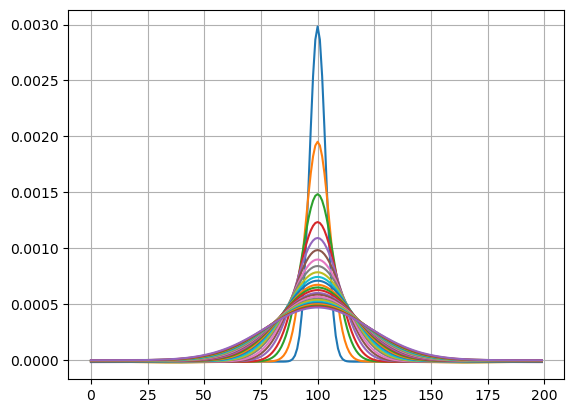

In [10]:
background = np.min(profiles[-1,:])
for i in range(steps):
    if i % 200 ==1:
        plt.plot(profiles[i]-background)
plt.grid()

In [11]:
def function_diffusion(t, D):
    return np.sqrt(2*D*t)

def profile_std(profile, background):
    profile = np.clip(profile - background, 0, np.inf)
    x = xp.arange(len(profile))
    total_mass = xp.sum(profile)
    x_mean = xp.sum(x * profile) / total_mass
    variance = xp.sum(profile * (x - x_mean) ** 2) / total_mass
    std = xp.sqrt(variance)
    return std

def calc_diff_coef(profiles):
    stds = []
    for i in range(profiles.shape[0]):
        stds.append(profile_std(profiles[i], background))
    stds = np.array(stds)
    t_axis = np.arange(profiles.shape[0])
    try:
        popt, pcov = curve_fit(function_diffusion, t_axis[1:], stds[1:])
    except Exception:
        return 0, 0
    return popt[0], stds

In [12]:
D, stds = calc_diff_coef(profiles)

/var/folders/89/5nqqf3_96xj25hvfk_qkg4740000gn/T/ipykernel_35533/2708721820.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*D*t)


Diffusion_constant =  0.05185839340206229


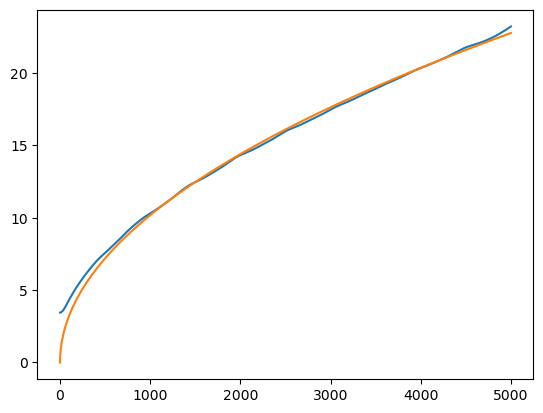

In [13]:
plt.plot(stds)
t_axis = np.arange(steps)
print("Diffusion_constant = ", D)
plt.plot(t_axis, function_diffusion(t_axis, D))

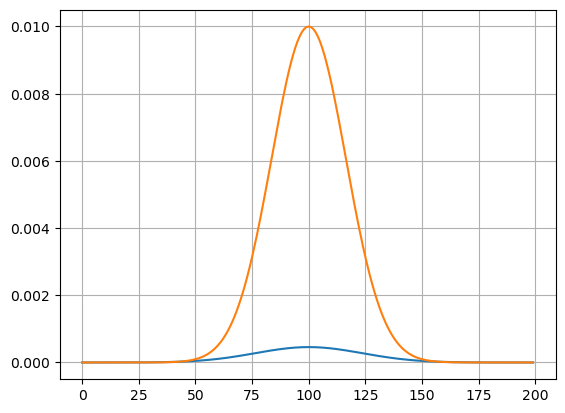

In [14]:

plt.plot(profiles[-1]-background)
plt.grid()

stripe_width = stds[-1]
x_coord = np.arange(nx)
x_gaussian = pow(np.e, -pow((x_coord-nx//2)/stripe_width, 2))
plt.plot(x_gaussian*0.01)